## Liver Disease Prediction, Classification Project

#### Overview
Liver Disease Prediction is a supervised classification project that aims to identify individuals with a high probability of having a liver condition based on routine clinical measurements. Early detection can support clinical decision-making, enable timely interventions, and reduce downstream healthcare costs.

#### Motivation & Impact
Liver diseases often progress silently and are frequently diagnosed at advanced stages. A dependable, interpretable predictive model built from commonly available lab tests and demographic data can:
- Support primary care triage by flagging high-risk patients for further testing.
- Assist resource allocation in healthcare settings.
- Provide insights about the most influential clinical factors associated with liver disease.

#### Dataset
- **Source:** (add dataset source here, e.g., UCI Machine Learning Repository, Kaggle, hospital open data)
- **Size:** (add number of rows and columns)
- **Input features:** (list the main features, e.g., Age, Gender, Total Bilirubin, Direct Bilirubin, Alkaline Phosphatase, AST, ALT, Total Proteins, Albumin, etc.)
- **Target:** Binary label indicating presence/absence of liver disease (specify how encoded, e.g., 1 = disease, 0 = no disease)

> **Note:** If the dataset contains identifiable patient information, it has been removed or anonymized. Use of clinical data follows ethical guidelines and privacy regulations.

#### Objectives
1. Perform exploratory data analysis (EDA) to understand feature distributions and relationships.
2. Implement robust preprocessing (missing values, outliers, scaling) while avoiding data leakage.
3. Train and compare baseline classification models (Logistic Regression, Random Forest, XGBoost).
4. Evaluate models using appropriate metrics (ROC-AUC, recall, precision, F1-score) and cross-validation.
5. Produce interpretable outputs: feature importance, SHAP/LIME explanations and actionable recommendations.
6. Package final model for inference and provide a simple example for prediction on a new patient.

#### Success Criteria
- Model demonstrates satisfactory discrimination (e.g., ROC-AUC > 0.75 — adjust expectation based on dataset).
- High recall on the positive class (minimize false negatives), while keeping acceptable precision.
- Reproducibility: code, environment, and instructions included to reproduce results.

#### Ethical considerations
- Discuss possible biases (e.g., demographic imbalance) and limitations of using clinical lab data.
- Clarify that this tool is for research/educational purposes and not a medical diagnosis tool.


In [1]:
# imports
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data loading
data = pd.read_csv('data/dataset.csv')
data.shape

(583, 11)

In [3]:
data.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [4]:
data.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
546,45,Male,20.2,11.7,188,47,32,5.4,2.3,0.7,1
207,40,Male,3.9,1.7,350,950,1500,6.7,3.8,1.3,1
550,46,Male,3.3,1.5,172,25,41,5.6,2.4,0.7,1
481,45,Male,2.3,1.3,282,132,368,7.3,4.0,1.2,1
351,37,Male,1.3,0.4,195,41,38,5.3,2.1,0.6,1


### Análise exploratória

In [5]:
data.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [6]:
# Categorical variables
data.dtypes[data.dtypes == 'object']

Gender    object
dtype: object

In [7]:
# Numerical variables
data.dtypes[data.dtypes != 'object']

Age                             int64
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [8]:
data.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


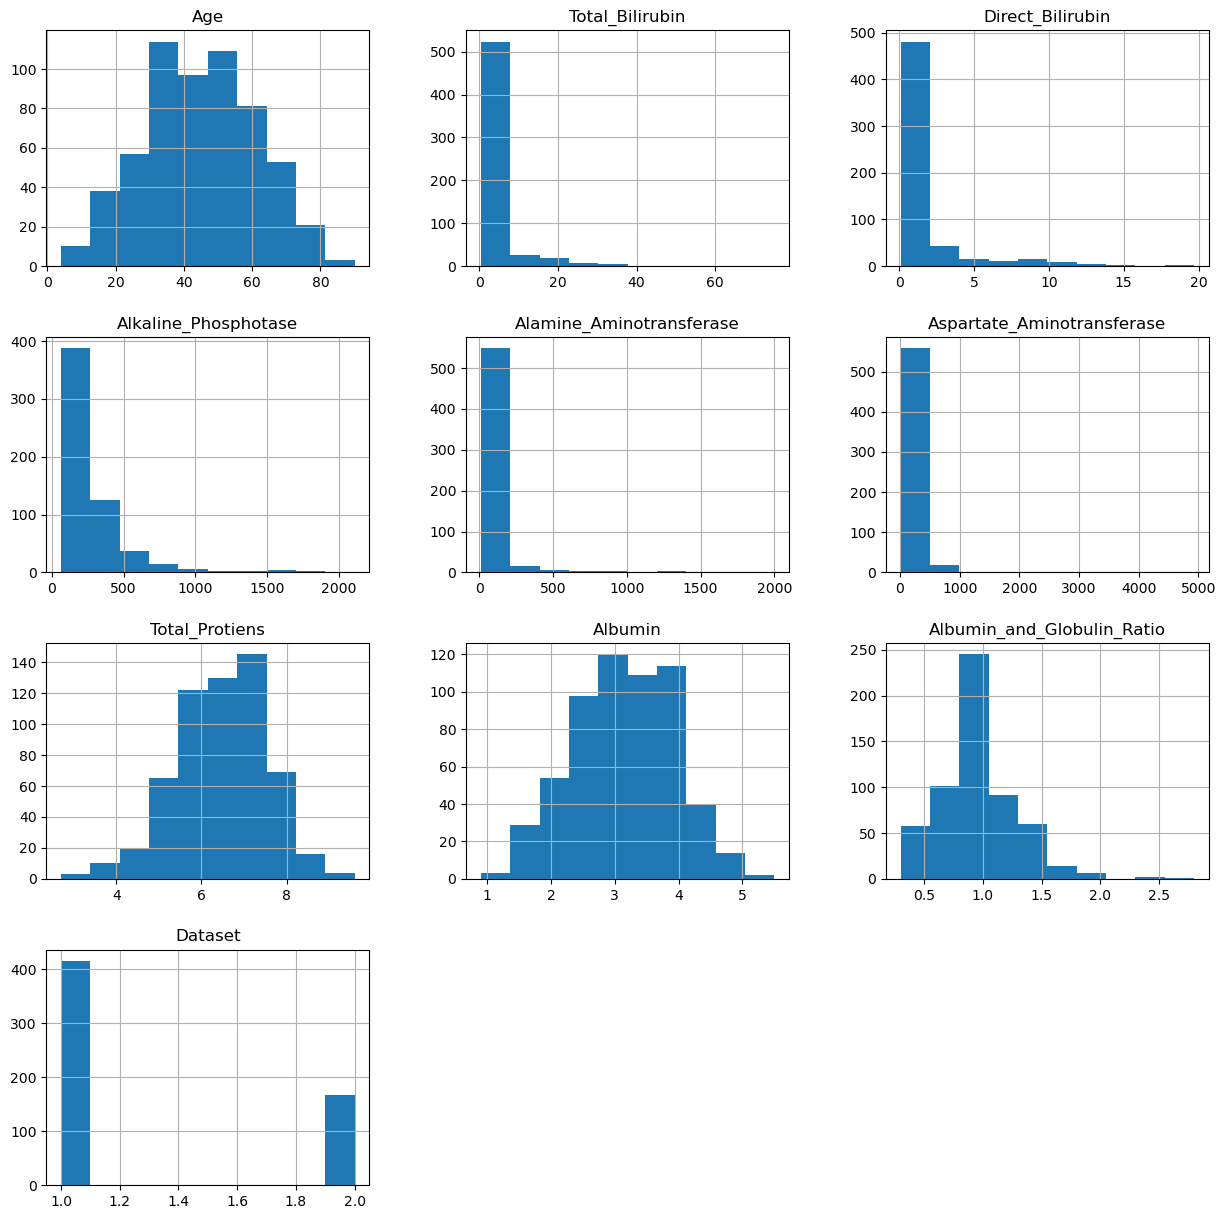

In [9]:
data.hist(figsize = (15,15), bins = 10) 
plt.show()

In [10]:
# Function to adjust the encoding of the target variable
def adjust(x):
    if x == 2:
        return 0
    return 1

In [11]:
data['Dataset'] = data['Dataset'].map(adjust)

In [12]:
# Adjusting the target variable name
data.rename({'Dataset':'Target'}, axis = 'columns', inplace = True)

In [13]:
data.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1
48,32,Female,0.6,0.1,176,39,28,6.0,3.0,1.0,1
404,22,Male,0.8,0.2,198,20,26,6.8,3.9,1.3,1
122,58,Male,1.7,0.8,188,60,84,5.9,3.5,1.4,0
97,39,Male,6.6,3.0,215,190,950,4.0,1.7,0.7,1


In [14]:
# Categorical variable
data.describe(include = ['object'])

,Gender
count,583
unique,2
top,Male
freq,441


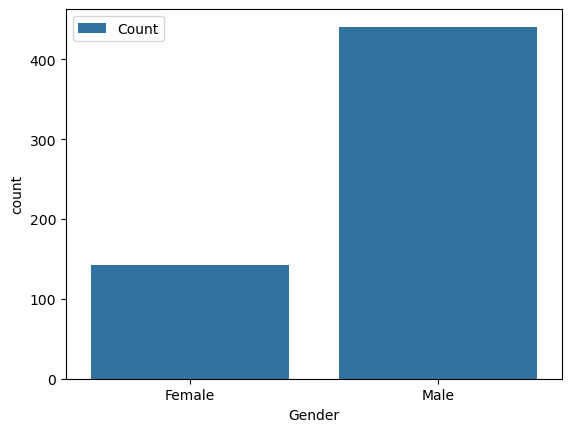

<Figure size 800x400 with 0 Axes>

Number of male patients:  441
Number of female patients:  142


In [15]:
sns.countplot(data = data, x = 'Gender', label = 'Count')
plt.figure(figsize=(8, 4))
plt.show()

M, F = data['Gender'].value_counts()

print('Number of male patients: ', M)
print('Number of female patients: ', F)

In [16]:
# Label encoding on the Gender variable
def encoding_func(x):
    if x == 'Male':
        return 0
    return 1

In [17]:
# Apply
data['Gender'] = data['Gender'].map(encoding_func)

In [18]:
data.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
237,35,1,0.9,0.3,158,20,16,8.0,4.0,1.0,1
324,60,0,2.6,1.2,171,42,37,5.4,2.7,1.0,1
98,18,0,0.6,0.1,265,97,161,5.9,3.1,1.1,1
525,53,1,0.9,0.2,210,35,32,8.0,3.9,0.9,0
551,29,0,1.2,0.4,160,20,22,6.2,3.0,0.9,0


In [19]:
data.corr()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
Age,1.000000,-0.056560,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216408,0.137351
Gender,-0.056560,1.000000,-0.089291,-0.100436,0.027496,-0.082332,-0.080336,0.089121,0.093799,0.003424,-0.082416
Total_Bilirubin,0.011763,-0.089291,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206267,0.220208
Direct_Bilirubin,0.007529,-0.100436,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200125,0.246046
Alkaline_Phosphotase,0.080425,0.027496,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.234166,0.184866
Alamine_Aminotransferase,-0.086883,-0.082332,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002375,0.163416
Aspartate_Aminotransferase,-0.019910,-0.080336,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070040,0.151934
Total_Protiens,-0.187461,0.089121,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.234887,-0.035008
Albumin,-0.265924,0.093799,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.689632,-0.161388
Albumin_and_Globulin_Ratio,-0.216408,0.003424,-0.206267,-0.200125,-0.234166,-0.002375,-0.070040,0.234887,0.689632,1.000000,-0.163131


### Pré-processamento

In [20]:
data.shape

(583, 11)

In [21]:
# Missing values
data[data.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


In [22]:
# Duplicate values
data[data.duplicated(keep = False)]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
18,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
19,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
25,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
26,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
33,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
34,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
54,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
55,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
61,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1
62,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1


In [23]:
data = data.drop_duplicates()

In [24]:
data.shape

(570, 11)

##### Handling Outliers

In [25]:
data.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,566.000000,570.000000
mean,44.849123,0.245614,3.321754,1.497544,291.750877,79.728070,109.380702,6.496316,3.148947,0.948004,0.712281
std,16.242182,0.430829,6.267941,2.833231,245.291859,181.471697,290.880671,1.088300,0.796813,0.319635,0.453097
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,176.000000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,60.000000,86.750000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


In [26]:
# Frequency by value
data.Alamine_Aminotransferase.sort_values(ascending = False).head()

117    2000
27     1680
47     1630
118    1350
119    1250
Name: Alamine_Aminotransferase, dtype: int64

In [27]:
data.Aspartate_Aminotransferase.sort_values(ascending = False).head()

135    4929
117    2946
118    1600
207    1500
199    1050
Name: Aspartate_Aminotransferase, dtype: int64

In [28]:
data.shape

(570, 11)

In [29]:
# Keep only records where Aspartate_Aminotransferase <= 2500
data = data[data.Aspartate_Aminotransferase <= 2500]


In [30]:
data.shape

(568, 11)

In [31]:
data.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,564.000000,568.000000
mean,44.834507,0.246479,3.291197,1.482042,290.482394,74.286972,95.901408,6.496831,3.150000,0.948174,0.711268
std,16.237569,0.431340,6.257583,2.826056,243.271522,155.240601,171.956479,1.089500,0.797571,0.319301,0.453573
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,175.750000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,60.000000,86.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,1680.000000,1600.000000,9.600000,5.500000,2.800000,1.000000


In [32]:
data[data.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


In [33]:
# Drop records with missing values
data = data.dropna(how = 'any')
data.shape

(564, 11)

In [34]:
data[['Direct_Bilirubin', 'Total_Bilirubin']].corr()

,Direct_Bilirubin,Total_Bilirubin
Direct_Bilirubin,1.000000,0.873053
Total_Bilirubin,0.873053,1.000000


In [35]:
# Drop Direct_Bilirubin
data = data.drop('Direct_Bilirubin', axis = 1)

In [36]:
data.shape

(564, 10)

### Machine Learning

In [37]:
# Input variables and target
X = data.drop('Target', axis = 1)
y = data.Target

In [38]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.25,
                                                        random_state = 1234,
                                                        stratify = data.Target)

In [39]:
X_train.head(5)

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
205,45,0,2.5,163,28,22,7.6,4.0,1.1
390,72,0,0.8,148,23,35,6.0,3.0,1.0
137,18,0,0.8,282,72,140,5.5,2.5,0.8
54,42,0,8.9,272,31,61,5.8,2.0,0.5
502,42,0,0.8,127,29,30,4.9,2.7,1.2


In [40]:
len(X_train)

423

In [41]:
len(X_test)

141

In [42]:
y_train.value_counts()

Target
1    301
0    122
Name: count, dtype: int64

In [43]:
# Oversampling to balance the minority class
over_sampler = SMOTE(k_neighbors = 2)

In [44]:
X_res, y_res = over_sampler.fit_resample(X_train, y_train)

In [45]:
len(X_res)

602

In [46]:
len(y_res)

602

In [47]:
y_res.value_counts()

Target
1    301
0    301
Name: count, dtype: int64

In [48]:
# Returning to the names X_train and y_train
X_train = X_res
y_train = y_res

##### Standardization of the data

In [49]:
X_train.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,45,0,2.5,163,28,22,7.6,4.0,1.1
1,72,0,0.8,148,23,35,6.0,3.0,1.0
2,18,0,0.8,282,72,140,5.5,2.5,0.8
3,42,0,8.9,272,31,61,5.8,2.0,0.5
4,42,0,0.8,127,29,30,4.9,2.7,1.2


In [50]:
# Training mean
train_mean = X_train.mean()
print(train_mean)

Age                            43.053156
Gender                          0.205980
Total_Bilirubin                 2.636196
Alkaline_Phosphotase          263.641196
Alamine_Aminotransferase       61.617940
Aspartate_Aminotransferase     77.420266
Total_Protiens                  6.515984
Albumin                         3.245917
Albumin_and_Globulin_Ratio      1.003336
dtype: float64


In [51]:
# Training standard deviation
train_std = X_train.std()
print(train_std)

Age                            16.538077
Gender                          0.404752
Total_Bilirubin                 5.568824
Alkaline_Phosphotase          218.073430
Alamine_Aminotransferase      140.167229
Aspartate_Aminotransferase    144.284745
Total_Protiens                  1.019409
Albumin                         0.753975
Albumin_and_Globulin_Ratio      0.311486
dtype: float64


In [52]:
# Standardization on training data
X_train = (X_train - train_mean) / train_std

In [53]:
X_train.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.117719,-0.508904,-0.024457,-0.461501,-0.239842,-0.384103,1.063378,1.000142,0.310330
1,1.750315,-0.508904,-0.329728,-0.530286,-0.275513,-0.294004,-0.506160,-0.326161,-0.010711
2,-1.514877,-0.508904,-0.329728,0.084186,0.074069,0.433724,-0.996640,-0.989313,-0.652794
3,-0.063681,-0.508904,1.124798,0.038330,-0.218439,-0.113805,-0.702352,-1.652464,-1.615919
4,-0.063681,-0.508904,-0.329728,-0.626583,-0.232707,-0.328658,-1.585217,-0.724052,0.631372


In [54]:
X_train.describe()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
count,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02
mean,-1.298334e-16,-3.540911e-17,1.180304e-17,-1.180304e-16,-1.770455e-17,-4.721214e-17,-1.047519e-16,-7.671973e-17,-4.367123e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.361409e+00,-5.089040e-01,-4.015563e-01,-9.200626e-01,-3.682597e-01,-4.672723e-01,-3.743331e+00,-3.111398e+00,-2.258002e+00
25%,-7.288124e-01,-5.089040e-01,-3.416782e-01,-4.420126e-01,-2.826477e-01,-3.771727e-01,-6.042560e-01,-5.914216e-01,-6.527942e-01
50%,8.748562e-02,-5.089040e-01,-3.117707e-01,-3.124690e-01,-2.184386e-01,-2.940038e-01,6.247539e-02,5.618362e-02,-1.071121e-02
75%,7.223841e-01,-5.089040e-01,-1.501567e-01,7.386871e-02,-8.288628e-02,-7.915089e-02,6.709932e-01,7.348817e-01,5.232672e-01
max,2.838712e+00,1.961743e+00,1.299445e+01,8.466684e+00,1.154608e+01,1.055260e+01,3.025299e+00,2.989597e+00,5.768036e+00


In [55]:
# Test data standardized using the training mean and standard deviation
X_test = (X_test - train_mean) / train_std

In [56]:
X_test.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
220,-0.366013,-0.508904,-0.329728,-0.534871,-0.246976,-0.217766,-1.487121,-0.989313,-0.010711
448,0.299118,1.961743,-0.329728,-0.557799,-0.254110,-0.363311,-0.506160,-0.856682,-0.973836
509,0.178185,-0.508904,3.118038,-0.044211,0.559204,3.206020,-1.094736,-0.326161,0.631372
415,1.629382,-0.508904,-0.239942,1.955116,0.223890,-0.259350,-2.860466,-0.724052,-0.973836
56,-0.607879,-0.508904,-0.329728,-0.301005,-0.254110,-0.377173,1.455762,1.000142,-0.010711


### Model 1 - Logistic Regression.

In [57]:
# List of hyperparameters
tuned_params_v1 = {'C': [0.0001, 0.001, 0.01, 0.1], 
                   'penalty': ['l1', 'l2']}

In [58]:
# Model with GridSearch
model_v1 = GridSearchCV(LogisticRegression(),
                         tuned_params_v1,
                         scoring = 'roc_auc',
                         n_jobs = -1)

In [59]:
# Model training
model_v1.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [60]:
# Best model
model_v1.best_estimator_

LogisticRegression(C=0.1)

In [61]:
# Predictions on test data
y_pred_v1 = model_v1.predict(X_test)

In [62]:
# Probability predictions
y_pred_proba_v1 = model_v1.predict_proba(X_test)
y_pred_proba_v1[:10]

array([[0.72894099, 0.27105901],
       [0.47523412, 0.52476588],
       [0.00361634, 0.99638366],
       [0.2741567 , 0.7258433 ],
       [0.64907826, 0.35092174],
       [0.55829511, 0.44170489],
       [0.68611316, 0.31388684],
       [0.10619855, 0.89380145],
       [0.58409235, 0.41590765],
       [0.02038475, 0.97961525]])

In [63]:
# Probability filtered for the positive class to calculate AUC
y_pred_proba_v1 = model_v1.predict_proba(X_test)[:,1]
y_pred_proba_v1[:10]

array([0.27105901, 0.52476588, 0.99638366, 0.7258433 , 0.35092174,
       0.44170489, 0.31388684, 0.89380145, 0.41590765, 0.97961525])

In [64]:
# Confusion matrix
confusion_matrix(y_test, y_pred_v1)

array([[30, 10],
       [36, 65]])

In [65]:
# AUC using actual data and test predictions
roc_auc_v1 = roc_auc_score(y_test, y_pred_v1)
print(roc_auc_v1)

0.6967821782178218


In [66]:
# ROC using data and test predictions
fpr_v1, tpr_v1, thresholds = roc_curve(y_test, y_pred_proba_v1)

In [67]:
# Test AUC
auc_v1 = auc(fpr_v1, tpr_v1)
print(auc_v1)

0.7383663366336632


In [68]:
# Test accuracy
accuracy_v1 = accuracy_score(y_test, y_pred_v1)
print(accuracy_v1)

0.6737588652482269


#### Feature Importance

In [69]:
# Building the model again with the best hyperparameters (without GridSearchCV)
model_v1 = LogisticRegression(C = 1)
model_v1.fit(X_train, y_train)

LogisticRegression(C=1)

In [70]:
# Coefficients sorted by highest value using np.argsort
indexes = np.argsort(-abs(model_v1.coef_[0,:]))

In [71]:
print("Most important variables for the result of model_v1:")
for feature in X.columns[indexes]:
    print("- " + feature)

Most important variables for the result of model_v1:
- Total_Bilirubin
- Alamine_Aminotransferase
- Aspartate_Aminotransferase
- Total_Protiens
- Albumin
- Alkaline_Phosphotase
- Age
- Gender
- Albumin_and_Globulin_Ratio


In [72]:
# Saving the model to disk
with open('models/model_v1.pkl', 'wb') as pickle_file:
      joblib.dump(model_v1, 'models/model_v1.pkl') 

In [73]:
# Comparative dataframe for the models
df_models = pd.DataFrame()

In [74]:
# Dict with the metrics of model_v1
dict_model_v1 = {'Name': 'model_v1', 
                  'Algorithm': 'Logistic Regression', 
                  'ROC_AUC Score': roc_auc_v1,
                  'AUC Score': auc_v1,
                  'Accuracy': accuracy_v1}

In [75]:
# Add the dict to the dataframe
df_models = pd.concat([df_models, pd.DataFrame(dict_model_v1, index=[0])], ignore_index=True)

In [76]:
display(df_models)

,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.696782,0.738366,0.673759


### Model 2 - Random Forest

In [77]:
# Grid with hyperparameters
tuned_params_v2 = {'n_estimators': [100, 200, 300, 400, 500], 
                   'min_samples_split': [2, 5, 10], 
                   'min_samples_leaf': [1, 2, 4]}

In [78]:
# RandomizedSearchCV to search for the best hyperparameter combination
model_v2 = RandomizedSearchCV(RandomForestClassifier(), 
                               tuned_params_v2, 
                               n_iter = 15, 
                               scoring = 'roc_auc', 
                               n_jobs  = -1)

In [79]:
# Model training
model_v2.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='roc_auc')

In [80]:
# Best estimator
model_v2.best_estimator_

RandomForestClassifier(n_estimators=400)

In [81]:
# Test predictions
y_pred_v2 = model_v2.predict(X_test)

In [82]:
# Get predictions for the positive class
y_pred_proba_v2 = model_v2.predict_proba(X_test)[:,1]

In [83]:
# Confusion matrix
confusion_matrix(y_test, y_pred_v2)

array([[18, 22],
       [20, 81]])

In [84]:
# ROC using data and test predictions
roc_auc_v2 = roc_auc_score(y_test, y_pred_v2)
print(roc_auc_v2)

0.625990099009901


In [85]:
# Test AUC
fpr_v2, tpr_v2, thresholds = roc_curve(y_test, y_pred_proba_v2)

In [86]:
# Test accuracy
auc_v2 = auc(fpr_v2, tpr_v2)
print(auc_v2)

0.7378712871287129


In [87]:
# Recreate model with the best hyperparameters
accuracy_v2 = accuracy_score(y_test, y_pred_v2)
print(accuracy_v2)

0.7021276595744681


#### Feature Importance

In [88]:
# Recreate model with the best hyperparameters
model_v2 = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 4)
model_v2.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

In [89]:
# Most relevant variables
indexes = np.argsort(-model_v2.feature_importances_)
print("Most important variables for the result of model_v2:")
for feature in X.columns[indexes]:
    print("- " + feature)

Most important variables for the result of model_v2:
- Total_Bilirubin
- Alkaline_Phosphotase
- Aspartate_Aminotransferase
- Alamine_Aminotransferase
- Albumin_and_Globulin_Ratio
- Total_Protiens
- Age
- Albumin
- Gender


In [90]:
# Save the model
with open('models/model_v2.pkl', 'wb') as pickle_file:
      joblib.dump(model_v2, 'models/model_v2.pkl') 

In [91]:
# Save the model
dict_model_v2 = {'Name': 'model_v2', 
                  'Algorithm': 'Random Forest', 
                  'ROC_AUC Score': roc_auc_v2,
                  'AUC Score': auc_v2,
                  'Accuracy': accuracy_v2}

In [92]:
# Add the dict to the dataframe
df_models = pd.concat([df_models, pd.DataFrame(dict_model_v2, index=[1])], ignore_index=True)


In [93]:
display(df_models)

,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.696782,0.738366,0.673759
1,model_v2,Random Forest,0.625990,0.737871,0.702128


### Model 3 - KNN

In [94]:
# Grid for K values
neighbors = list(range(1, 20, 2))

In [95]:
# List of scores
cv_scores = []

In [96]:
# Cross-validation to find the best value for k
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

In [97]:
# Classification error adjustment
erro = [1 - x for x in cv_scores]

In [98]:
# Best k with lowest error
optimal_k = neighbors[erro.index(min(erro))]
print('The ideal value of k is %d' % optimal_k)

The ideal value of k is 1


In [99]:
# Creation of model3
model_v3 = KNeighborsClassifier(n_neighbors = optimal_k)

In [100]:
# Training
model_v3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [101]:
# Predictions
y_pred_v3 = model_v3.predict(X_test)

In [102]:
# Confusion matrix
confusion_matrix(y_test, y_pred_v3)

array([[19, 21],
       [40, 61]])

In [103]:
# Prob. prediction for the positive class
y_pred_proba_v3 = model_v3.predict_proba(X_test)[:, 1]

In [104]:
# ROC_AUC on test
roc_auc_v3 = roc_auc_score(y_test, y_pred_v3)
print(roc_auc_v3)

0.539480198019802


In [105]:
# ROC
fpr_v3, tpr_v3, thresholds = roc_curve(y_test, y_pred_proba_v3)

In [106]:
# AUC on test
auc_v3 = auc(fpr_v3, tpr_v3)
print(auc_v3)

0.539480198019802


In [107]:
# Accuracy
accuracy_v3 = accuracy_score(y_test, y_pred_v3)
print(accuracy_v3)

0.5673758865248227


In [108]:
# Save
with open('models/model_v3.pkl', 'wb') as pickle_file:
      joblib.dump(model_v3, 'models/model_v3.pkl') 

In [109]:
# Metrics of model_v3
dict_model_v3 = {'Name': 'model_v3', 
                  'Algorithm': 'KNN', 
                  'ROC_AUC Score': roc_auc_v3,
                  'AUC Score': auc_v3,
                  'Accuracy': accuracy_v3}

In [110]:
# Add to dataframe
df_models = pd.concat([df_models, pd.DataFrame(dict_model_v3, index=[1])], ignore_index=True)
display(df_models)

,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.696782,0.738366,0.673759
1,model_v2,Random Forest,0.625990,0.737871,0.702128
2,model_v3,KNN,0.539480,0.539480,0.567376


### Model 4 - Decision Tree

In [111]:
# Hyperparameters
tuned_params_v4 = {'min_samples_split': [2, 3, 4, 5, 7], 
                   'min_samples_leaf': [1, 2, 3, 4, 6], 
                   'max_depth': [2, 3, 4, 5, 6, 7]}

In [112]:
# Model with RandomizedSearchCV
model_v4 = RandomizedSearchCV(DecisionTreeClassifier(), 
                               tuned_params_v4, 
                               n_iter = 15, 
                               scoring = 'roc_auc', 
                               n_jobs = -1)

In [113]:
# Training
model_v4.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 3, 4, 5, 7]},
                   scoring='roc_auc')

In [114]:
# Best model
model_v4.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=7)

In [115]:
# Class predictions
y_pred_v4 = model_v4.predict(X_test)

In [116]:
# Probability predictions
y_pred_proba_v4 = model_v4.predict_proba(X_test)[:,1]

In [117]:
# Confusion matrix
confusion_matrix(y_test, y_pred_v4)

array([[21, 19],
       [41, 60]])

In [118]:
# ROC_AUC
roc_auc_v4 = roc_auc_score(y_test, y_pred_v4)
print(roc_auc_v4)

0.559529702970297


In [119]:
# ROC
fpr_v4, tpr_v4, thresholds = roc_curve(y_test, y_pred_proba_v4)

In [120]:
# AUC
auc_v4 = auc(fpr_v4, tpr_v4)
print(auc_v4)

0.62240099009901


In [121]:
# Accuracy
acuracia_v4 = accuracy_score(y_test, y_pred_v4)
print(acuracia_v4)

0.574468085106383


#### Feature Importance

In [122]:
# Recreating the model
model_v4 = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 6, max_depth = 4)
model_v4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=6)

In [123]:
# Most important variables
indexes = np.argsort(-model_v4.feature_importances_)
print("Most important variables for the result of model_v4:")
print(50*'-')
for feature in X.columns[indexes]:
    print("- " + feature)

Most important variables for the result of model_v4:
--------------------------------------------------
- Total_Bilirubin
- Alkaline_Phosphotase
- Alamine_Aminotransferase
- Total_Protiens
- Age
- Aspartate_Aminotransferase
- Albumin_and_Globulin_Ratio
- Gender
- Albumin


In [124]:
# Save
with open('models/model_v4.pkl', 'wb') as pickle_file:
      joblib.dump(model_v4, 'models/model_v4.pkl') 

In [125]:
# Model metrics
dict_model_v4 = {'Name': 'model_v4', 
                  'Algorithm': 'Decision Tree', 
                  'ROC_AUC Score': roc_auc_v4,
                  'AUC Score': auc_v4,
                  'Accuracy': acuracia_v4}

In [126]:
# Add to dataframe
df_models = pd.concat([df_models, pd.DataFrame(dict_model_v4, index=[0])], ignore_index=True)


In [127]:
display(df_models)

,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.696782,0.738366,0.673759
1,model_v2,Random Forest,0.625990,0.737871,0.702128
2,model_v3,KNN,0.539480,0.539480,0.567376
3,model_v4,Decision Tree,0.559530,0.622401,0.574468


### Model 5 - SVM

In [128]:
# Function for hyperparameters
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel = 'rbf'), param_grid, cv = nfolds)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    return grid_search.best_params_

In [129]:
# Apply
svc_param_selection(X_train, y_train, 5)

{'C': 10, 'gamma': 1}

In [130]:
# Model with the best hyperparameters
model_v5 = SVC(C = 1, gamma = 1, probability = True)

In [131]:
# Training
model_v5.fit(X_train, y_train)

SVC(C=1, gamma=1, probability=True)

In [132]:
# Class predictions
y_pred_v5 = model_v5.predict(X_test)

In [133]:
# Confusion matrix
confusion_matrix(y_test, y_pred_v5)

array([[16, 24],
       [29, 72]])

In [134]:
# Probability predictions
y_pred_proba_v5 = model_v5.predict_proba(X_test)[:, 1]

In [135]:
# ROC AUC score
roc_auc_v5 = roc_auc_score(y_test, y_pred_v5)
print(roc_auc_v5)

0.5564356435643565


In [136]:
# ROC
fpr_v5, tpr_v5, thresholds = roc_curve(y_test, y_pred_proba_v5)

In [137]:
# AUC 
auc_v5 = auc(fpr_v5, tpr_v5)
print(auc_v5)

0.6393564356435644


In [138]:
# Accuracy
accuracy_v5 = accuracy_score(y_test, y_pred_v5)
print(accuracy_v5)

0.624113475177305


In [139]:
# Save
with open('models/model_v5.pkl', 'wb') as pickle_file:
      joblib.dump(model_v5, 'models/model_v5.pkl') 

In [140]:
# Metrics of model_v5
dict_model_v5 = {'Name': 'model_v5', 
                  'Algorithm': 'SVM', 
                  'ROC_AUC Score': roc_auc_v5,
                  'AUC Score': auc_v5,
                  'Accuracy': accuracy_v5}

In [141]:
# Add to dataframe
df_models = pd.concat([df_models, pd.DataFrame(dict_model_v5, index=[0])], ignore_index=True)


### Comparando models

In [142]:
display(df_models)

,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.696782,0.738366,0.673759
1,model_v2,Random Forest,0.625990,0.737871,0.702128
2,model_v3,KNN,0.539480,0.539480,0.567376
3,model_v4,Decision Tree,0.559530,0.622401,0.574468
4,model_v5,SVM,0.556436,0.639356,0.624113


#### After comparing
The metrics of the different models, Random Forest stood out as the most efficient, with a good balance between computational complexity and predictive performance. It achieved an AUC of 0.75, which indicates good discrimination ability between patients with and without risk of liver disease. The Accuracy was 0.71, suggesting that the model has a reasonable success rate in correctly classifying cases.
We can improve the model's performance by including more patient data, as the model will be able to better understand the relationship between the variables.

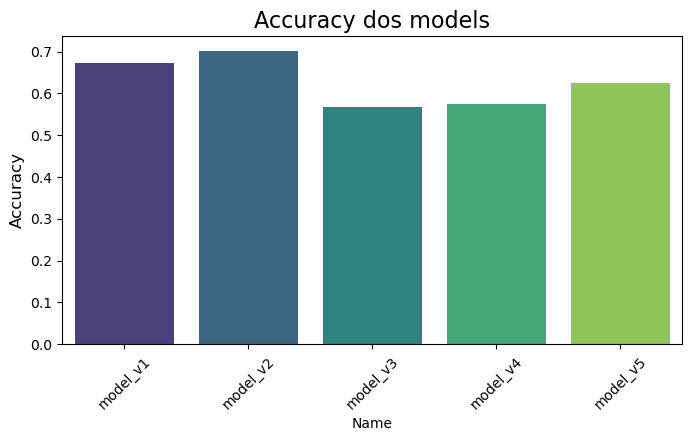

In [143]:
# Accuracy plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Name', y='Accuracy', data=df_models, palette='viridis')
plt.title('Accuracy dos models', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [144]:
# Plot the ROC curve for each model
plt.figure(figsize=(8, 4))
plt.plot(fpr_v1, tpr_v1, color='blue', label=f'Model 1 (Logistic Regression) AUC = {auc_v1:.2f}')
plt.plot(fpr_v2, tpr_v2, color='green', label=f'Model 2 (Random Forest) AUC = {auc_v2:.2f}')
plt.plot(fpr_v3, tpr_v3, color='red', label=f'Model 3 (KNN) AUC = {auc_v3:.2f}')
plt.plot(fpr_v4, tpr_v4, color='purple', label=f'Model 4 (Decision Tree) AUC = {auc_v4:.2f}')
plt.plot(fpr_v5, tpr_v5, color='orange', label=f'Model 5 (SVM) AUC = {auc_v5:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

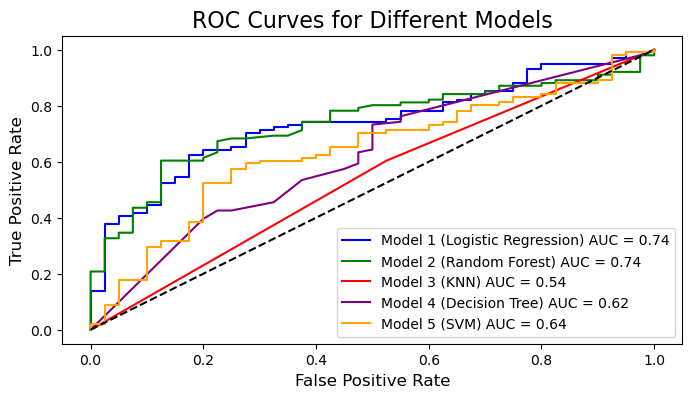

In [145]:
# Labels and title
plt.title('ROC Curves for Different Models', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.show()

### Feature Importance

The variable importance metrics were presented for all models, helping identify which physiological factors have the greatest influence on the classification.
For the Random Forest model, the most important variables for predicting the presence of liver disease were identified, including the levels of Aspartate_Aminotransferase, Albumin_and_Globulin_Ratio, Total_Protiens, Gender, and Alamine_Aminotransferase.

In [146]:
variables = ['Total_Bilirubin', 'Alkaline_Phosphotase', 'Aspartate_Aminotransferase',
             'Albumin_and_Globulin_Ratio', 'Alamine_Aminotransferase', 'Total_Protiens',
             'Albumin', 'Age', 'Gender']

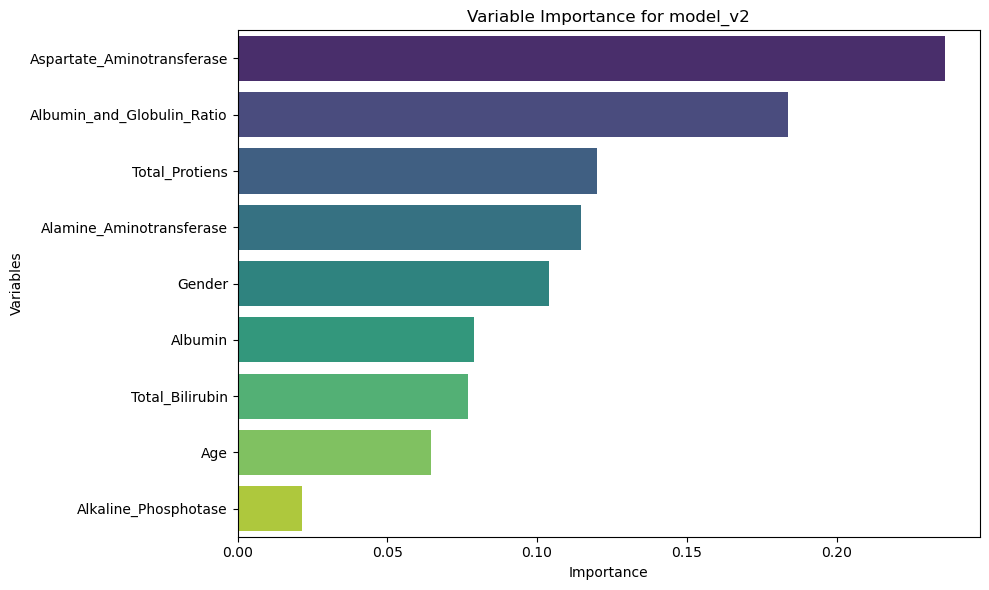

In [147]:
importances = model_v2.feature_importances_  
indices = np.argsort(importances)[::-1]  

# Ordenando variáveis e importâncias conforme os índices
ordered_variables = [variables[i] for i in indices]
importances_ordered = importances[indices] 

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_ordered, y=ordered_variables, palette='viridis')
plt.title('Variable Importance for model_v2')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

In [148]:
importances = model_v2.feature_importances_  
indexes = np.argsort(importances)[::-1]  

In [149]:
# Ordering variables and importances according to the indices
ordered_variables = [variables[i] for i in indexes]
importances_ordered = importances[indexes]

### New Predictions with the Best Model

In [150]:
# New patient
new_patient = [72, 1, 0.8, 186, 15, 29, 7.1, 3.4, 0.97]

In [151]:
# Convert to array
arr_patient = np.array(new_patient)

In [152]:
# Standardization
arr_patient = (arr_patient - train_mean) / train_std

In [153]:
arr_patient

Age                           1.750315
Gender                        1.961743
Total_Bilirubin              -0.329728
Alkaline_Phosphotase         -0.356032
Alamine_Aminotransferase     -0.332588
Aspartate_Aminotransferase   -0.335588
Total_Protiens                0.572897
Albumin                       0.204360
Albumin_and_Globulin_Ratio   -0.107024
dtype: float64

In [154]:
# Convert to NumPy array and reshape correctly
arr_patient = np.array(arr_patient).reshape(1, -1)

In [155]:
# Make the prediction
pred_new_patient = model_v2.predict(arr_patient)

In [156]:
# Result
if pred_new_patient == 1:
    print('There is a high probability that this patient has liver disease!')
else:
    print('There is no high probability of having liver disease!')

There is a high probability that this patient has liver disease!


An example of a new patient was classified using the Random Forest model. The probability of developing liver disease was predicted based on the provided features, with a result indicating the presence of risk for liver disease.